<a id='toc0_'></a>    
- [Подготовка](#toc1_)    
- [Случайная политика](#toc2_)    
- [A2C](#toc3_)    
  - [pyTorch](#toc3_1_)    
  - [StableBaselines3](#toc3_2_)    
    - [Обучение](#toc3_2_1_)    
    - [Визуализация](#toc3_2_2_)    
- [Выводы](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Подготовка](#toc0_)

In [18]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Normal
from pathlib import Path
import imageio
from IPython.display import HTML, display
import time

from IPython.display import clear_output, display
import matplotlib.pyplot as plt

In [24]:
%matplotlib notebook

In [19]:
def visualize(gif_path="car_racing.gif", model=None):
    env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=True)
    frames = []

    obs, _ = env.reset()
    terminated = False
    truncated = False

    while not (terminated or truncated):
        if model is None:
            action = env.action_space.sample()
        # --- Вариант 2: StableBaselines3 ---
        elif hasattr(model, "predict"):
            action, _ = model.predict(obs, deterministic=True)

        # --- Вариант 3: PyTorch---
        else:
            with torch.no_grad():
                device = next(model.parameters()).device
                state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                q_values = model(state)
                action = int(torch.argmax(q_values, dim=1).item())
                
        obs, _, terminated, truncated, _ = env.step(action)

        frame = env.render()
        frames.append(frame)

    env.close()

    # GIF
    with imageio.get_writer(gif_path, mode="I", duration=0.05) as writer:
        for frame in frames:
            writer.append_data(frame)

    # Уникальный query параметр для браузера
    cache_buster = time.time()
    display(HTML(f'<img src="{gif_path}?v={cache_buster}">'))

# <a id='toc2_'></a>[Случайная политика](#toc0_)

In [3]:
visualize(gif_path='car_racing_random.gif')

# <a id='toc3_'></a>[A2C](#toc0_)

## <a id='toc3_1_'></a>[pyTorch](#toc0_)

In [28]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym
import matplotlib.pyplot as plt

In [29]:
#  Гиперпараметры
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OBS_H, OBS_W = 64, 64
FRAME_STACK = 4
GAMMA       = 0.99
GAE_LAMBDA  = 0.95
LR_ACTOR    = 1e-4
LR_CRITIC   = 3e-4
NUM_EPISODES = 150

In [30]:
#  Среда
env = gym.make(
    "CarRacing-v3",
    render_mode=None,
    lap_complete_percent=0.95,
    domain_randomize=False,
    continuous=True
)
ACTION_DIM = env.action_space.shape[0]  # 3



In [31]:

#  Обработка наблюдений
def preprocess_frame(obs):
    """
    obs: (96,96,3) uint8 RGB
    -> (64,64) float32 в [0,1] (grayscale)
    """
    img = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)         # (96,96)
    img = cv2.resize(img, (OBS_W, OBS_H), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0                # [0,1]
    return img  # (64,64)


def init_stack(obs):
    """Создаём стек из FRAME_STACK одинаковых кадров."""
    frame = preprocess_frame(obs)                       # (H,W)
    stack = np.stack([frame] * FRAME_STACK, axis=-1)    # (H,W,C)
    return stack


def update_stack(stack, obs):
    """Обновляем стек: сдвиг + новый кадр в конец по каналам."""
    frame = preprocess_frame(obs)                       # (H,W)
    frame = frame[..., None]                            # (H,W,1)
    stack = np.concatenate([stack[..., 1:], frame], axis=-1)
    return stack


def prep_obs(s):
    """
    s: np.ndarray или torch.Tensor
       (H,W,C) или (N,H,W,C)
    -> (N,C,H,W) float32 на DEVICE
    """
    x = torch.as_tensor(s, dtype=torch.float32, device=DEVICE)
    if x.dim() == 3:          # (H,W,C)
        x = x.permute(2, 0, 1).unsqueeze(0)  # (1,C,H,W)
    elif x.dim() == 4:        # (N,H,W,C)
        x = x.permute(0, 3, 1, 2)            # (N,C,H,W)
    else:
        raise ValueError(f"Unexpected obs shape: {x.shape}")
    return x

In [42]:
#  Сети: Actor и Critic
class ActorNet(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(FRAME_STACK, 32, kernel_size=8, stride=4),  # (64 -> 15)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),           # (15 -> 6)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),           # (6 -> 4)
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(64 * 4 * 4, hidden_dim)

        self.mu_head = nn.Linear(hidden_dim, ACTION_DIM)
        # Стартуем с довольно большого std, чтобы был хороший exploration
        self.log_std = nn.Parameter(torch.ones(ACTION_DIM) * 0.5)

    def forward(self, s):
        x = prep_obs(s)            # (N, C, H, W)
        x = self.conv(x)
        x = self.flatten(x)
        x = F.relu(self.hidden(x))
        mu = self.mu_head(x)       # (N,3)
        std = self.log_std.exp()
        std = torch.clamp(std, 0.1, 1.0)
        std = std.expand_as(mu)
        return mu, std


class ValueNet(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(FRAME_STACK, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(64 * 4 * 4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        x = prep_obs(s)
        x = self.conv(x)
        x = self.flatten(x)
        x = F.relu(self.hidden(x))
        v = self.output(x)         # (N,1)
        return v.squeeze(-1)       # (N,)


actor = ActorNet().to(DEVICE)
critic = ValueNet().to(DEVICE)

opt_actor = torch.optim.AdamW(actor.parameters(), lr=LR_ACTOR)
opt_critic = torch.optim.AdamW(critic.parameters(), lr=LR_CRITIC)


#  Выбор действия
def select_action(state_stack):
    """
    state_stack: (H,W,FRAME_STACK) np
    return:
      env_action: np.array(3,) – то, что уходит в env.step
      raw_action: np.array(3,) – "сырой" action до squashing (для log_prob)
    """
    with torch.no_grad():
        mu, std = actor(state_stack)       # (1,3)
        dist = Normal(mu, std)
        raw = dist.sample()                # (1,3)

        # squash в диапазоны среды
        steering = torch.tanh(raw[..., 0])      # [-1,1]
        gas      = torch.sigmoid(raw[..., 1])   # [0,1]
        brake    = torch.sigmoid(raw[..., 2])   # [0,1]

        env_action = torch.stack([steering, gas, brake], dim=-1)  # (1,3)

    return (
        env_action.squeeze(0).cpu().numpy().astype(np.float32),
        raw.squeeze(0).cpu().numpy().astype(np.float32),
    )


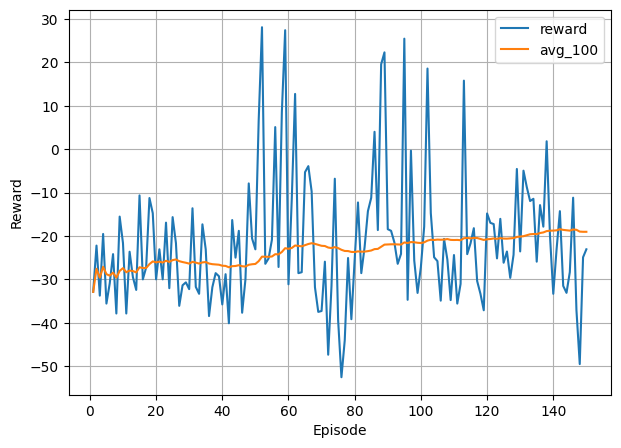


Training finished.


In [43]:
#  Тренировка (A2C + GAE)
reward_history = []
avg100_history = []

plt.ion()
fig, ax = plt.subplots(figsize=(7, 5))
line_r,   = ax.plot([], [], label="reward")
line_a100, = ax.plot([], [], label="avg_100")
ax.set_xlabel("Episode")
ax.set_ylabel("Reward")
ax.legend()
ax.grid(True)

for ep in range(NUM_EPISODES):
    obs, _ = env.reset()
    state = init_stack(obs)
    done = False

    states = []
    raw_actions = []
    rewards = []
    dones = []          # именно terminal-done, не truncated!
    

    while True:
        states.append(state.copy())

        env_action, raw_action = select_action(state)


        terminated = False
        truncated = False
        
            
        obs, r, terminated, truncated, _ = env.step(env_action)
        state = update_stack(state, obs)

        raw_actions.append(raw_action)
        rewards.append(r)

        # сохраняем только терминал для GAE!
        dones.append(1.0 if terminated else 0.0)

        if terminated or truncated:
            break

    #в тензоры
    states_t      = torch.tensor(np.array(states), dtype=torch.float32, device=DEVICE)
    raw_actions_t = torch.tensor(np.array(raw_actions), dtype=torch.float32, device=DEVICE)
    rewards_t     = torch.tensor(np.array(rewards), dtype=torch.float32, device=DEVICE)
    rewards_t = (rewards_t - rewards_t.mean()) / (rewards_t.std() + 1e-8)
    dones_t = torch.tensor(dones, dtype=torch.float32, device=DEVICE)
    # actor/critic forward на всём эпизоде
    mu, std = actor(states_t)                  # (T,3)
    dist = Normal(mu, std)
    log_probs = dist.log_prob(raw_actions_t).sum(-1)  # (T,)
    values = critic(states_t)                             # (T,)

    #GAE
    T = len(rewards)
    advantages = torch.zeros(T, device=DEVICE)
    gae = 0.0

    # добавляем V(s_{T}) = 0 для терминала
    values_ext = torch.cat([values, torch.zeros(1, device=DEVICE)], dim=0)

    for t in reversed(range(T)):
        not_done = 1.0 - dones_t[t]  # truncated → 1, terminated → 0

        delta = rewards_t[t] + GAMMA * values_ext[t+1] * not_done - values_ext[t]
        gae = delta + GAMMA * GAE_LAMBDA * not_done * gae
        advantages[t] = gae

        returns = advantages + values

    # Critic update
    opt_critic.zero_grad()
    critic_loss = F.mse_loss(values, returns.detach())
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
    opt_critic.step()

    # Actor update
    adv_norm = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    opt_actor.zero_grad()
    policy_loss = -(log_probs * adv_norm.detach()).mean()
    # добавим энтропии для exploration
    entropy = dist.entropy().sum(-1).mean()
    loss_actor_total = policy_loss - 0.001 * entropy
    loss_actor_total.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
    opt_actor.step()

    #логирование 
    ep_reward = float(sum(rewards))
    reward_history.append(ep_reward)
    if len(reward_history) < 100:
        avg100 = float(np.mean(reward_history))
    else:
        avg100 = float(np.mean(reward_history[-100:]))
    avg100_history.append(avg100)

    # онлайн-график
    x = np.arange(1, len(reward_history) + 1)
    line_r.set_data(x, reward_history)
    line_a100.set_data(x, avg100_history)
    ax.relim()
    ax.autoscale_view()
    clear_output(wait=True)
    display(fig)
    plt.pause(0.001)



    # зададим целевую награду и выход
    if len(reward_history) >= 100 and avg100 > 300.0:
        print("\nTarget reached, stopping.")
        break

print("\nTraining finished.")
env.close()
plt.ioff()
plt.show()


In [34]:
torch.save(actor.state_dict(), 'actor.pt')
torch.save(critic.state_dict(), 'critic.pt')

## <a id='toc3_2_'></a>[StableBaselines3](#toc0_)

In [35]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.callbacks import BaseCallback


### <a id='toc3_2_1_'></a>[Обучение](#toc0_)

In [ ]:
# Колбэк с онлайн-графиком
class RewardPlotCallback(BaseCallback):
    def __init__(self, ax, log_freq=5000, ma_points=10, verbose=0):
        super().__init__(verbose)
        self.ax = ax
        self.log_freq = log_freq
        self.ma_points = ma_points

        self.x = []
        self.y = []               # средняя награда по батчам
        self._buffer = []         # буфер наград между логами

        (self.line_raw,) = self.ax.plot([], [], marker="o", lw=1, label="avg reward")
        (self.line_ma,) = self.ax.plot([], [], lw=2, label=f"moving avg ({ma_points})")

        self.ax.set_xlabel("training steps")
        self.ax.set_ylabel("reward")
        self.ax.set_title("Reward")
        self.ax.grid(True)
        self.ax.legend()

    def _on_step(self) -> bool:
        # средняя награда по всем параллельным env в этом шаге
        r = float(np.mean(self.locals["rewards"]))
        self._buffer.append(r)

        if self.n_calls % self.log_freq == 0:
            avg_r = float(np.mean(self._buffer))
            self._buffer.clear()

            self.x.append(self.n_calls)
            self.y.append(avg_r)

            # обновляем "сырую" линию
            self.line_raw.set_data(self.x, self.y)

            # считаем скользящее среднее
            if len(self.y) >= self.ma_points:
                y_arr = np.array(self.y)
                kernel = np.ones(self.ma_points) / self.ma_points
                y_ma = np.convolve(y_arr, kernel, mode="valid")
                x_ma = self.x[self.ma_points - 1 :]
                self.line_ma.set_data(x_ma, y_ma)

            # авто-масштаб
            self.ax.relim()
            self.ax.autoscale_view()

            # перерисовка
            clear_output(wait=True)
            display(fig)
            if self.verbose:
                print(f"[{self.n_calls}] avg reward = {avg_r:.2f}")

        return True

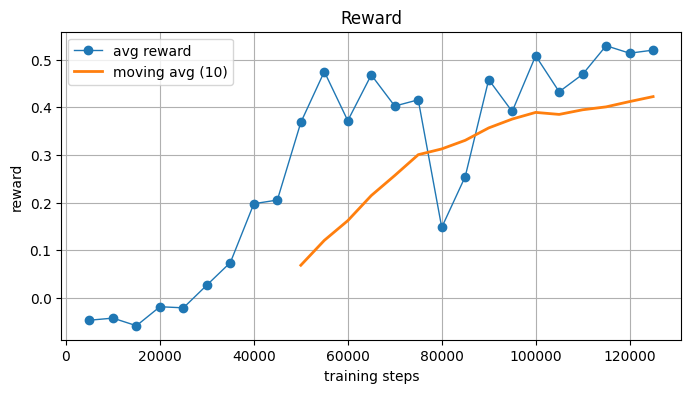

[125000] avg reward = 0.52


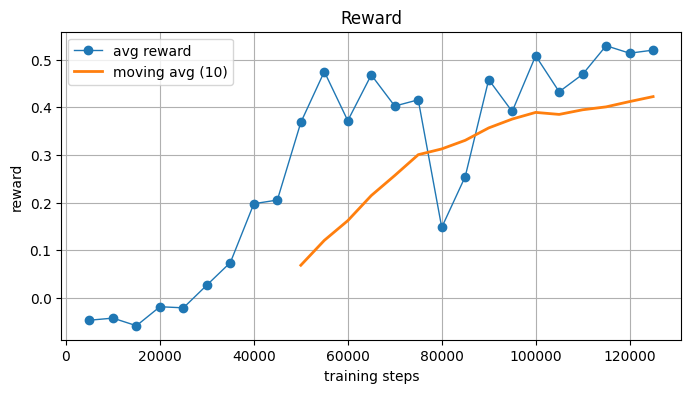

In [37]:
# Окружение + модель
# 8 параллельных окружений, без рендера – для скорости
vec_env = make_vec_env(
    "CarRacing-v3",
    n_envs=8,
    env_kwargs=dict(
        render_mode=None,
        lap_complete_percent=0.95,
        domain_randomize=False,
        continuous=True,
    ),
)

# (H, W, C) -> (C, H, W) для CnnPolicy
vec_env = VecTransposeImage(vec_env)

# 3. Matplotlib: онлайн-режим
plt.ion()
fig, ax = plt.subplots(figsize=(8, 4))

callback = RewardPlotCallback(ax=ax, log_freq=5000, ma_points=10, verbose=1)

model = A2C(
    "CnnPolicy",
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    n_steps=5 * 8,     
    gamma=0.99,
    ent_coef=0.0001,
)

model.learn(total_timesteps=1_000_000, callback=callback)
model.save("a2c_car_racing")

plt.ioff()
plt.show()  


### <a id='toc3_2_2_'></a>[Визуализация](#toc0_)

In [38]:
visualize(model=model,gif_path='car_racing_a2c.gif')

# <a id='toc4_'></a>[Выводы](#toc0_)
Cреда "CarRacing-v3" является  сложной для решения так как у нее обзерватион RGB-картинка и непрерывное пространство действий.

Случайная политика ожидаемо не может решить среду.
Решение на pyTorch показывает стабильный рост награды от эпизода, но очень медленный прогресс.
требуется дальнейшее усложнение агентов и обучения, но тогда сильно вырастет время обучения.

Решение от StableBaselines3 работает стабильнее и быстрее учится , для более четкого следования трассе требуется увеличить число шагов обучения. Но полученный агент уже показывет движение к цели, пусть и с некоторыми уходами с трассы. 

A2C позволяет решать среду "CarRacing-v3", но наблюдатся низкая стабильность обучения, возможны "срывы" обучения.
Для надежного решения среды лучше применить "более продвинутые" алгоритмы типа PPO 